<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_07_GoChar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Rationale

Why MongoDB here? <br> <br>

The core 'engine' of Parashar21 is designed to cast horoscopes using the [Python](https://pypi.org/project/pyswisseph/) version of the [Swiss Ephemeris](https://www.astro.com/swisseph/) software, convert the data to JSON format and then store the same in a MongoDB database.<br> The Mongo query language was next used to filter out horoscopes that met certain criteria and then create human readable MS-Word documents for each selected horoscope. <br> <br>
For full information about this project, please see the [Parashar21](https://prithwis.github.io/parashar21/) github page.


#SetUp Environment

##Install Software

In [5]:
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                #https://python-docx.readthedocs.io/en/latest/
#!/usr/bin/python3 -m pip install "pymongo[srv]"            # Required only if used with Atlas remote servers
!apt install mongodb > /dev/null                            # install local MongoDB server           
!service mongodb start                                      # start Local MongoDB server instance

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 5.6 MB 5.0 MB/s 


 * Starting database mongodb
   ...done.


##Install, import prerequisites

In [6]:
#Utility functions 
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files

#import matplotlib.pyplot as plt
#import math


In [7]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions 
# ---------------------------

#!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png                 
#!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png   



In [31]:
import p21
import p21utils
import p21utilsR
import p21swe
import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
importlib.reload(p21YogInfo)

10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 : Adhi678 Yog | Benefics located in 6/7/8th  from Moon
4 : Chandra Mangal Yog | Mars Conjoins Moon or  Mars and Moon in Mutual Aspect
5 : Kemadruma Yog : No planets on either sides of the Moon
6 : Anapha Yog |Planets other than Sun in 12th Place from Moon
7 : Sunapha Yog |Planets other than Sun in 2nd Place from Moon
8 : Dhurdhura Yog | Planets on both sides of the Moon
9 : Gajakesari Yog | Jupiter is in Kendra or 1,4,7,10th from Moon


<module 'p21YogInfo' from '/content/p21YogInfo.py'>

In [9]:
#Download Swiss Ephemeris Files 
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

#Local Mongo

We use a locally installed, temporary MongoDB to store and process the data


## Natal Data used to cast horscopes
Data for others can be added by adding an extra line in the cell below. Please follow the same pattern as in the other lines


In [18]:
%%writefile peopleData.csv
Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
M,17,9,1950,23:11,5.5,23.48,72.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil
F,10,10,1954,11:00,5.5,13.08,80.27,IST,standard,Rekha,Actor,nil,Dancer,nil,nil,nil
M,15,10,1931,1:15,5.5,9.29,79.31,IST,standard,APJAbdulKalam,Engineer,nil,PublicFigure,nil,nil,nil
F,19,11,1917,23:11,5.5,25.43,81.85,IST,standard,IndiraG,Politician,nil,PublicFigure,nil,nil,nil

Overwriting peopleData.csv


In [ ]:
#!cat peopleData.csv

In [11]:
!cat peopleData.csv

Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Ram,Engineer,nil,Teacher,nil,PostGraduate,nil
F,19,12,1965,10:26,5.5,22.57,88.37,IST,standard,Shyam,Author,nil,Homemaker,nil,PostGraduate,nil
M,9,10,1990,23:09,5.5,22.57,88.37,IST,standard,Jadu,Engineer,nil,Teacher,nil,PostGraduate,nil
F,12,9,1990,0:52,5.5,22.87,88.37,IST,standard,Madhu,Biologist,nil,Scientist,nil,PostGraduate,nil
M,17,9,1950,23:11,5.5,23.48,72.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil


In [33]:
#Read Birth Data from a file
!wget -O peopleData.csv -q https://raw.githubusercontent.com/prithwis/parashar21/main/data/Test5Data.txt # 5 Person Test Data


In [34]:
#Now Add Gochar data
#
now = datetime.now(pytz.timezone('Asia/Kolkata'))
timeTxt = now.strftime("%-d,%-m,%Y,%-H:%-M")
GocharTxt = 'x,'+timeTxt+',5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil'
with open("peopleData.csv", 'a') as file1:
    file1.write(GocharTxt)

In [35]:
!cat peopleData.csv

Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Ram,Engineer,nil,Teacher,nil,PostGraduate,nil
F,19,12,1965,10:26,5.5,22.57,88.37,IST,standard,Shyam,Author,nil,Homemaker,nil,PostGraduate,nil
M,9,10,1990,23:09,5.5,22.57,88.37,IST,standard,Jadu,Engineer,nil,Teacher,nil,PostGraduate,nil
F,12,9,1990,0:52,5.5,22.87,88.37,IST,standard,Madhu,Biologist,nil,Scientist,nil,PostGraduate,nil
M,17,9,1950,23:11,5.5,23.48,72.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil
x,3,10,2022,18:48,5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil

In [37]:
# 
# Load CSV data into Pandas dataframe
#
df0 = pd.read_csv('peopleData.csv')
df0.head(10)

,Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
0,M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Ram,Engineer,nil,Teacher,nil,PostGraduate,nil
1,F,19,12,1965,10:26,5.5,22.57,88.37,IST,standard,Shyam,Author,nil,Homemaker,nil,PostGraduate,nil
2,M,9,10,1990,23:09,5.5,22.57,88.37,IST,standard,Jadu,Engineer,nil,Teacher,nil,PostGraduate,nil
3,F,12,9,1990,0:52,5.5,22.87,88.37,IST,standard,Madhu,Biologist,nil,Scientist,nil,PostGraduate,nil
4,M,17,9,1950,23:11,5.5,23.48,72.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil
5,x,3,10,2022,18:48,5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil


In [38]:
#%%time
#
p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']
p21.ChartType = p21.AnalysisType
p21.Gochar = True
p21.Subject = 'Ram'
# 
# ------------------------------------------------------------
# Converts date/time info into a detailed horoscope chart 
# Stores the same in a JSON file, to be inserted into a local MongoDB database
# 
p21swe.C61_Cast2JSON(df0)

Gochar True
Subject found Ram
1 records processed, so far
Gochar True
Gochar True
Gochar True
Gochar True
Gochar True
La long reset to  250.52
6  records generated and stored in file peopleData.json


##Load the SINGLE chart into the local MongoDB

In [39]:
mongoURI = "mongodb://localhost:27017/"                               # for local server
client = MongoClient(mongoURI)
db = client.parashar21
#pd.DataFrame(list(db.list_collections()))

!mongoimport --db parashar21 --collection khona21 --drop --file peopleData.json

p21.kollection = db.khona21                   # Set the collection to work with
#kollection = db.khona21                   # Set the collection to work with
totalCharts = p21.kollection.count_documents({})
dbSize = db.command( {"dbStats": 1, "scale": 1024 } )['dataSize']
print(totalCharts, ' documents,',round(dbSize,2), " KB data")

2022-10-03T13:18:40.011+0000	connected to: localhost
2022-10-03T13:18:40.011+0000	dropping: parashar21.khona21
2022-10-03T13:18:40.049+0000	imported 6 documents
6  documents, 22.13  KB data


#Report Generation Function
Please note that the generated report MS Office doc format **will be stored in the Colab VM drive** and needs to be downloaded to local machine for viewing

In [40]:
def genChart(ChartStyle):
      
    #chartData = chart.iloc[0]
    chartData = df.iloc[0]
    #RepID = chart.iloc[0]['pid']['name']+'_'+p21.AnalysisType[0:3]+'_'+ChartStyle[0:1]
    RepID = df.iloc[0]['pid']['name']+'_'+p21.AnalysisType[0:3]+'_'+ChartStyle[0:1]
    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    fileName = 'p21_'+RepID+'_'+now.strftime("%H%M%S")+'.doc'

    #print(chartData)
    # ---------------------------------------------------------
    p21utilsR.R01_CreateReportDoc(None,None,'SingleChart')        # Creates MS Word Doc called p21.document for Single or MULTIPLE charts
    #p21utilsR.R01A_CreateReportDoc(RepID)                           # Creates MS Word Doc called p21.document for SINGLE chart
    # ----------------------------------------------------------
    for chart in range(len(df)):
        #chartData =df4Report.iloc[chart]
        chartData =df.iloc[chart]
        p21utilsR.R511_parseChartData(chartData)                # Break up database data into useful pieces
                                                                # Creates two primary dicts, GLon, GRet
        p21utilsR.R30_LocateYogs()
        
        #print(p21.beneficG)
        for ctype in ['Rashi','Navamsa']:
            p21.ChartType = ctype
            p21utils.R11_LocateGrahaInRashi()   # Converts Graha Long to Rashi positions
                                                # Rashi Num as well as Rashi name
            if ChartStyle == 'Bengal':
                p21utilsR.R12B_drawChart_Bengal()    # Draw Chart in Bengal style
            if ChartStyle == 'South':
                p21utilsR.R12B_drawChart_South()    # Draw Chart in South style
            if ChartStyle == 'North':
                p21utilsR.R12B_drawChart_North()    # Draw Chart in North style
            
        
        p21utilsR.R512_FormatPage()                  # this is where the details of the chart are printed out
    
    # ------------------------------------
    p21.document.save(fileName)
    return fileName
    
print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2022-10-03 18:48:43.853660+05:30


#Retrieve Charts 
Reports will be available as DOC files in the VM drive <br>
Please specify style of report, 'Bengal', 'North' or 'South' while calling the report generation routine <br>


## Retrieve, Display and Analyse the SingleChart chart

In [41]:
#
#Get List of Persons whose charts are found in the database
#
selCond = {}                                              # All Charts
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1,'_id':0})))
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))


,pid
0,{'name': 'Ram'}
1,{'name': 'Shyam'}
2,{'name': 'Jadu'}
3,{'name': 'Madhu'}
4,{'name': 'NDModi'}
5,{'name': '_Gochar'}


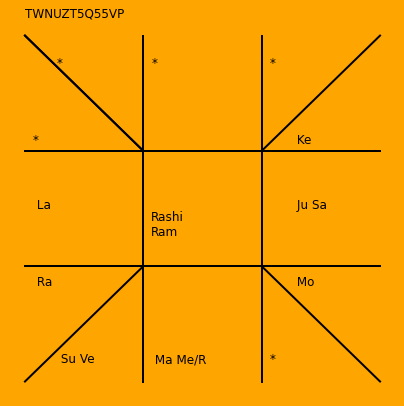

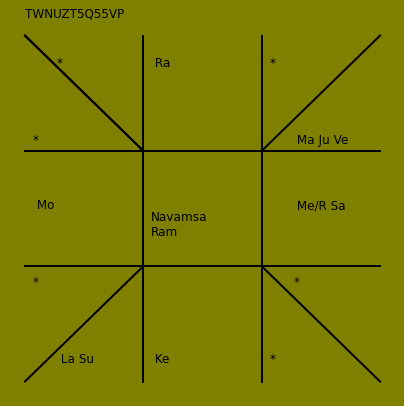

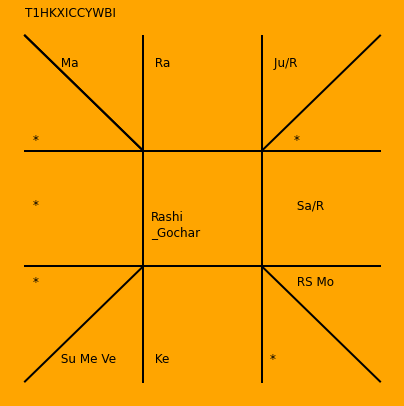

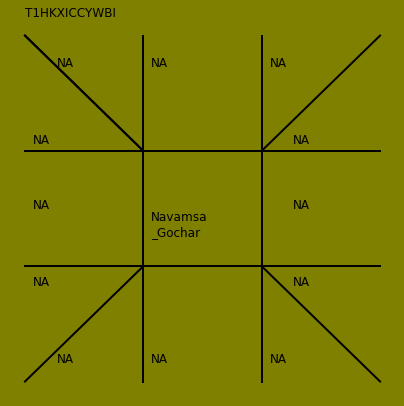

In [42]:
#%%capture
#
# Generate Report File for one person
#
#selCond = {'pid.name': {'$eq': 'APJAbdulKa'}}               # Single Person
#selCond = {"pid.name": {"$regex":"^per"}}                # Name starting with per

selCond = {'$or':[{'pid.name': {'$eq': p21.Subject[0:10]}} ,{'pid.name': {'$eq': '_Gochar'}}]}              # Single Person
#selCond = {'$or':[{'pid.name': {'$eq': 'NDModi'}} ,{'pid.name': {'$eq': '_Gochar'}}]}              # Single Person

#chart = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
df = pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols).sort("pid.name", 1)))
df
#chart.iloc[0]['pid']['name']
ReportFile = genChart('Bengal')


In [ ]:
#
# Download last Report File
#
files.download(ReportFile)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
!rm *.doc

#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

#Testing Stuff

In [ ]:
print(chart['beneficG'])

0    {'Su': True, 'Mo': True, 'Ma': True, 'Me': Fal...
Name: beneficG, dtype: object


In [ ]:
chart

,pid,GLon,GRet,Lord,GrahaLordBhav,GRashiN,GrahaBhava,LordBhav,exaltG,debilG,...,inEnemyL,GAspects2,GAspectedBy2,BAspectedBy2,BAspectedByBL2,GConjunctsG2,BLConjunctsG2,BLConjunctsBL2,beneficG,maleficG
0,"{'tags': ['Politician', 'PublicFigure', 'nil']...","{'La': 117.372, 'Su': 214.13, 'Mo': 275.593, '...","{'La': False, 'Su': False, 'Mo': False, 'Ma': ...","[ , Mo, Su, Me, Ve, Ma, Ju, Sa, Sa, Ju, Ma, Ve...","{'Su': [2], 'Mo': [1], 'Ma': [5, 10], 'Me': [3...","{'La': 4, 'Su': 8, 'Mo': 10, 'Ma': 5, 'Me': 8,...","{'La': 1, 'Su': 5, 'Mo': 7, 'Ma': 2, 'Me': 5, ...","[ , 7, 5, 5, 6, 2, 11, 1, 1, 11, 2, 6, 5]","{'Su': False, 'Mo': False, 'Ma': False, 'Me': ...","{'Su': False, 'Mo': False, 'Ma': False, 'Me': ...",...,"[False, False, False, False, False, False, Tru...","{'La': ['Mo'], 'Su': ['Ju'], 'Mo': ['La', 'Sa'...","{'Mo': ['La', 'Sa', 'Ju'], 'Ju': ['Su', 'Me'],...","{'7': ['La', 'Sa', 'Ju'], '11': ['Su', 'Me'], ...","{'1': ['1'], '3': ['9', '6', '8', '7'], '5': [...","{'Su': ['Me'], 'Me': ['Su'], 'Ve': ['Ra'], 'Ra...","{'2': ['Me'], '3': ['Su'], '4': ['Ra'], '11': ...","{'2': ['12', '3'], '3': ['2'], '12': ['2']}","{'Su': False, 'Mo': True, 'Ma': True, 'Me': Fa...","{'Su': False, 'Mo': False, 'Ma': False, 'Me': ..."


In [ ]:
#%%time
# Converts date/time info into a detailed horoscope chart 
# Stores the same in a JSON file, to be inserted into a local MongoDB database

p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']

p21.ChartType = p21.AnalysisType

writeFile =  open("peopleData.json", "w")  
for person in range(len(df)):
    try :
        personData =df.iloc[person]
        p21swe.C02_parsePersonData(personData)                  # split the data, extract required data into fields
                                                                # create skeleton chart json doc as p21.chart
        p21swe.C03_convertDates()                               # convert date, time of birth into universal time, calculate Ayanamsha
        p21swe.C04_calculateGrahaPositions()                    # calculate the Lon of each Graha along with Retrograde staus

                    #Horoscope is defined in terms of Natal Longitudes and Retrogrades
                    # for example
                    #GLon = {"La":98.5,"Su":178.9,"Mo":250.6,"Ma":196.2,"Me":193.2,"Ju":274.8,"Ve":153.8,"Sa":270.2,"Ra":122.1,"Ke":302.1}
                    #GRet = {"La":False,"Su":False,"Mo":False,"Ma":False,"Me":True,"Ju":False,"Ve":False,"Sa":False,"Ra":True,"Ke":True}

        p21swe.C05_buildGLonGRet()                              # create two json docs ( python dicts) to store Graha Lon and Ret status
                                                                # these are stored as global variables p21.GLon, p21.GRet
        p21utils.appendDict(p21.chart,p21.GLonRet)              # add Lon, Ret information to chart
        
        # ----------------------------------------
        p21utils.R11_LocateGrahaInRashi()
        
        p21utils.C10_DetermineBhavs()                           # determine Houses for person
        p21utils.appendDict(p21.chart,p21.BhavNBhavA)           # add BhavN, BhavA information to chart   
         
        # ----------------------------------------    
        p21utils.C11_DetermineLord()                            # determine Lords of Bhavs
        p21utils.appendDict(p21.chart,p21.LordInfo)             #  add information on Lords   

        p21utils.C12_BhavOfGraha_Lord()
        p21utils.appendDict(p21.chart,p21.BhavOfGraha_LordInfo) #  add information on Bhav Residency of Graha and Lords  
        
        
        p21utils.C21_DeterminePositions()
        p21utils.appendDict(p21.chart,p21.Positions)            #  add information on Graha / Lord POSITIONS  

        p21utils.C31_DetermineAspects()
        p21utils.appendDict(p21.chart,p21.Aspects)              #  add information on Graha / Lord ASPECTS  

        p21utils.C41_DetermineConjuncts()           
        p21utils.appendDict(p21.chart,p21.Conjuncts)            #  add information on Graha / Lord Conjuncts

        p21utils.C51_DetermineBenMal()
        #print(p21.BenMalG)
        p21utils.appendDict(p21.chart,p21.BenMalG)            #  add information on Benefic, Malefic Grahas
    except :
        print('error on record ', person)
    else :
        #insert_result = kollection.insert_one(p21.chart)        # insert one json doc, chart to database
        #insert_result.acknowledged                              # Confirms that insert is successful
                                                                 # Bypassing insertion into MongoDB will make processing much faster
        json.dump(p21.chart, writeFile)                          # Storing chart data as JSON file
    finally:
        if ( person % 1000 ) == 0:
            print(person, "records processed")
    
writeFile.close()


0 records processed


In [ ]:
print(ord(174))

TypeError: ignored

In [ ]:
print(p21.GAspects2)

{'La': ['Ke'], 'Ma': ['Ke', 'Ju'], 'Ju': ['Ve'], 'Sa': ['La', 'Ma', 'Ra', 'Ju'], 'Ke': ['La', 'Ma']}


In [ ]:
print(p21.GConjunctsG2)

{'Su': ['Ke', 'Me'], 'Me': ['Ke', 'Su'], 'Ke': ['Su', 'Me'], 'Mo': ['Ma'], 'Ma': ['Mo'], 'Ve': ['Sa'], 'Sa': ['Ve']}


In [ ]:
print(p21.exaltG)

{'Su': False, 'Mo': False, 'Ma': False, 'Me': True, 'Ju': False, 'Ve': False, 'Sa': False}


In [ ]:
print(p21.exaltL)

[False, False, False, False, False, False, False, False, False, False, False, False, False]


In [ ]:
print(p21.GRashiA)

{'La': 'Meen', 'Su': 'Simha', 'Mo': 'Kumbh', 'Ma': 'Simha', 'Me': 'Tula', 'Ju': 'Vrish', 'Ve': 'Tula', 'Sa': 'Makar', 'Ra': 'Mithun', 'Ke': 'Dhanu'}
